# RDKit IPython Tools Tutorial
**This is still WIP!**

This tutorial shows some of the features of the RDKit IPython Tools. For installation of the tools, please refer to the main [README.md](../README.md).

**Note:** Many features (like the notebook widgets or the JSME) are only correctly displayed when the notebook is actually run, not when it is just displayed in NBviewer.

## Initialization
### Required Modules
1. RDKit IPython Tools by A. Pahl ([link](https://github.com/apahl/rdkit_ipynb_tools))
1. Bokeh

### Highly Recommended Notebook Extensions ([Link](https://github.com/ipython-contrib/jupyter_contrib_nbextensions))
1. ExecuteTime
1. Freeze
1. Hide Input / Hide Input All
1. Table of Contents

In [1]:
%reload_ext autoreload
%autoreload 2

from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

# The next two lines are for optical reasons only. They can be safely disabled.
Draw.DrawingOptions.atomLabelFontFace = "DejaVu Sans"
Draw.DrawingOptions.atomLabelFontSize = 18

from rdkit_ipynb_tools import tools, pipeline as p

#from IPython.core.display import HTML, Javascript, display_png, clear_output, display

misc_tools.apl_tools                          (commit: 8e6690a ( 2016-02-21 16:05:07 ))
- no local installation of highcharts found, using web version.
rdkit_ipynb_tools.hc_tools                    (commit: 7fdc686 ( 2016-09-13 22:00:39 ))


Loading BokehJS ...

rdkit_ipynb_tools.tools                       (commit: 7fdc686 ( 2016-09-13 22:00:39 ))
- no local installation of JSME found, using web version.


## Example Data Set
Endothelin Receptor A (ET-A) Antagonists from ChEMBL, downloaded as tab-separated file on 31-Aug-2016, gzipped.

### Preparation
Count the lines and display the first line

In [2]:
!zcat chembl_et-a_antagonists.txt.gz | wc -l
print()
!zcat chembl_et-a_antagonists.txt.gz | head -n 1

2324

CMPD_CHEMBLID	MOLREGNO	PARENT_CMPD_CHEMBLID	PARENT_MOLREGNO	MOL_PREF_NAME	COMPOUND_KEY	MOLWEIGHT	ALOGP	PSA	NUM_RO5_VIOLATIONS	CANONICAL_SMILES	ACTIVITY_ID	STANDARD_TYPE	RELATION	STANDARD_VALUE	STANDARD_UNITS	PCHEMBL_VALUE	ACTIVITY_COMMENT	DATA_VALIDITY_COMMENT	POTENTIAL_DUPLICATE	BAO_ENDPOINT	UO_UNITS	QUDT_UNITS	ASSAY_ID	ASSAY_CHEMBLID	ASSAY_TYPE	DESCRIPTION	ASSAY_SRC_ID	ASSAY_SRC_DESCRIPTION	ASSAY_ORGANISM	ASSAY_STRAIN	ASSAY_TAX_ID	CURATED_BY	BAO_FORMAT	TID	TARGET_CHEMBLID	TARGET_TYPE	PROTEIN_ACCESSION	PREF_NAME	ORGANISM	CONFIDENCE_SCORE	TARGET_MAPPING	APD_NAME	APD_CONFIDENCE	DOC_ID	DOC_CHEMBLID	PUBMED_ID	JOURNAL	YEAR	VOLUME	ISSUE	FIRST_PAGE	CELL_ID	CELL_CHEMBL_ID	CELL_NAME

gzip: stdout: Broken pipe


We have 2323 records and a number of fields of which we will only need a few.

### Curating the Data Set with Pipelines
Pipelines are part of the tools to deal with arbitrarily large data sets with compound-awareness. This is achieved using Python generators.<br>
We will use them to curate the data set for our needs:
1. Read in the data set *(here directly as gzipped file)*
1. Transform the IC50 into a pIC50 (personal pet peeve, ask me about it ;-) )
1. Keep only the fields that we are interested in
1. Rename a field
1. Filter for high-activity compounds
1. Generate the structures from Smiles
1. Calculate some physicochemical properties
1. Finally, write everything to an SD file

The individual elements of the data stream are dictionaries and can be directly accessed by the `custom_man` and `custom_filter` components, using normal dict syntax (e.g. rec["&lt;field&gt;"]).<br>
This allows a wide of manipulations on the data stream.<br>
Empty fields are removed from the `rec` dict, so checks for existance before use are necessary in the `custom_xxx` components.

`custom_man` and `custom_filter` use `eval()` for running the code.

In [3]:
s = p.Summary()  # optional, used for logging what the individual components do

# code for IC50 --> pIC50 conversion
run_code = """
if "STANDARD_VALUE" in rec:
    rec["ETA_pIC50"] = tools.pic50(rec["STANDARD_VALUE"], "nM")"""  

# code for filtering high-activity compounds
run_filter = '"ETA_pIC50" in rec and rec["ETA_pIC50"] >= 8'

# define the start of the pipeline, can work directly with gzipped files
rd = p.start_csv_reader("chembl_et-a_antagonists.txt.gz", summary=s)

res = p.pipe(rd,
             (p.pipe_custom_man, run_code),
             (p.pipe_keep_props, ["CMPD_CHEMBLID", "CANONICAL_SMILES", "ETA_pIC50"]),
             (p.pipe_custom_filter, run_filter, {"summary": s}),
             (p.pipe_rename_prop, "CMPD_CHEMBLID", "Chembl_Id"),
             (p.pipe_mol_from_smiles, "CANONICAL_SMILES"),
             (p.pipe_calc_props, ["2d", "logp", "tpsa", "mw"]),
             # p.stop_count_records
             (p.stop_sdf_writer, "chembl_et-a_ant_active.sdf")
            )

""


<IPython.core.display.Javascript object>

The progress of the pipeline is displayed in a HTML table below the cell and can also be monitored by watching the automatically created `pipeline.log` file:<br>
Execute this in a **separate** terminal:

`<workdir>$ watch -n 2 cat pipeline.log`

### Available Pipeline Components

| Starting                   | Running                    | Stopping
|----------------------------|----------------------------|---------------------------|
| start_cache_reader         | pipe_calc_props            | stop_cache_writer         |
| start_csv_reader           | pipe_custom_filter         | stop_count_records        |
| start_mol_csv_reader       | pipe_custom_man            | stop_csv_writer           |
| start_sdf_reader           | pipe_do_nothing            | stop_dict_from_stream     |
| start_stream_from_dict     | pipe_has_prop_filter       | stop_mol_list_from_stream |
| start_stream_from_mol_list | pipe_id_filter             | stop_sdf_writer           |
|                            | pipe_inspect_stream        |                           |
|                            | pipe_join_data_from_file   |                           |
|                            | pipe_keep_largest_fragment |                           |
|                            | pipe_keep_props            |                           |
|                            | pipe_merge_data            |                           |
|                            | pipe_mol_filter            |                           |
|                            | pipe_mol_from_b64          |                           |
|                            | pipe_mol_from_smiles       |                           |
|                            | pipe_mol_to_b64            |                           |
|                            | pipe_mol_to_smiles         |                           |
|                            | pipe_neutralize_mol        |                           |
|                            | pipe_remove_props          |                           |
|                            | pipe_rename_prop           |                           |
|                            | pipe_sim_filter            |                           |


## The Mol_List
The main workhorse of the RDKit IPython Tools.<br>
A literal list of molecules (molecule objects), a subclass of the trusted Python list.

It can be populated by loading an SD file, from a *normal* list of molecules or as the end point of a Pipeline.

In [5]:
mol_list = tools.load_sdf("chembl_et-a_ant_active.sdf")

  > sdf chembl_et-a_ant_active loaded with 430 records.


In [6]:
print([x for x in sorted(dir(mol_list)) if not x.startswith("_")])

['add_id', 'align', 'append', 'bar', 'calc_props', 'clear', 'copy', 'copy_prop', 'correlate', 'count', 'd', 'extend', 'field_types', 'fields', 'get_ids', 'grid', 'has_prop_filter', 'hist', 'ia', 'id_prop', 'index', 'insert', 'join_data_from_file', 'keep_props', 'len', 'mol_filter', 'mols_with_prop', 'nested', 'new_list_from_ids', 'order', 'order_props', 'plot_tool', 'pop', 'prop_filter', 'recalc_needed', 'remove', 'remove_dups_by_id', 'remove_dups_by_struct', 'remove_empty_props', 'remove_props', 'rename_prop', 'reverse', 'scatter', 'set_default', 'set_prop_on_mol', 'show_cpd', 'sort', 'sort_list', 'summary', 'table', 'write_grid', 'write_nested', 'write_sdf', 'write_table']


Please use the documentation generated by Sphinx as described in `doc/README.md` or the context help (press shift-tab in the parentheses) for reference, e.g.:<br>

In [50]:
# Cell is frozen, i.e. blocked from execution. 
# Very useful if you do not accidentally want to start a long-running cell again
tmp = mol_list.remove_dups_by_struct()

### Overviews

In [7]:
mol_list.summary()

In [8]:
mol_list.correlate()

### Report Tables
All the reports shown here can also be written to file in HTML format, just use the mol_list.write_xxx() method instead.

#### Mol Table
The `table` is the default view of a Mol_List and can be invoked by just calling the mol_list:

#,Molecule,Chembl_Id,ETA_pIC50,LogP,MW,TPSA
0,,CHEMBL287683,10.85,4.88,559.66,110
1,,CHEMBL293830,10.52,4.96,493.99,118
2,,CHEMBL286621,10.32,3.51,520.58,130
3,,CHEMBL419367,10.26,4.79,618.65,105
4,,CHEMBL289216,10.24,4.38,520.58,119

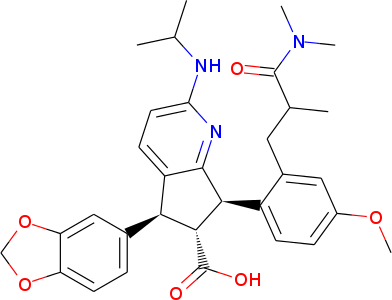
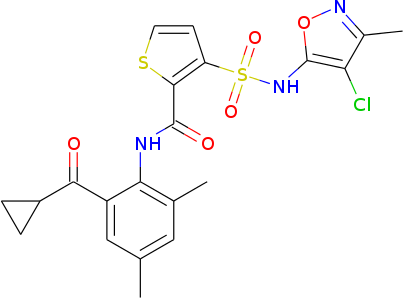
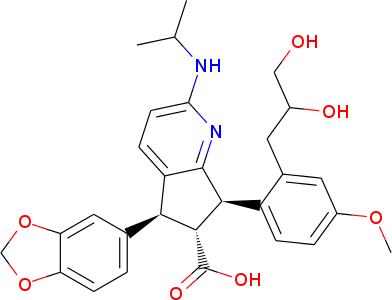
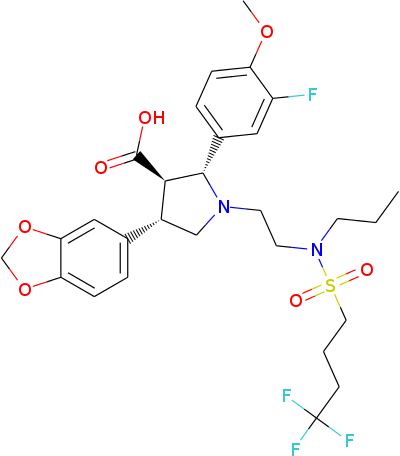
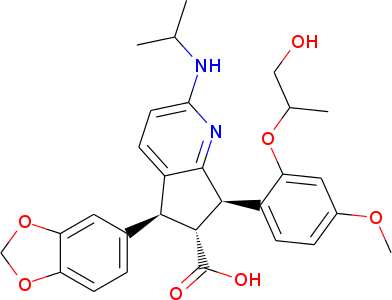

In [9]:
mol_list[:5]  # displays the first 5 molecules of the list
#  equivalent to:  mol_list.table()  # pagesize=5

So, this is nice, but what if we want to see more than 5 molecules? Displaying the whole list would flood the notebook and not be very convenient.

This is where the widgets of the notebook come in handy and allow a page-wise display of the molecules:

#,Molecule,Chembl_Id,ETA_pIC50,LogP,MW,TPSA
0,,CHEMBL287683,10.85,4.88,559.66,110
1,,CHEMBL293830,10.52,4.96,493.99,118
2,,CHEMBL286621,10.32,3.51,520.58,130
3,,CHEMBL419367,10.26,4.79,618.65,105
4,,CHEMBL289216,10.24,4.38,520.58,119
5,,CHEMBL62112,10.22,4.96,481.98,118
6,,CHEMBL37920,10.19,5.32,532.64,110
7,,CHEMBL432521,10.1,4.23,447.54,118
8,,CHEMBL58359,10.1,4.20,444.54,125
9,,CHEMBL293398,10.05,5.02,460.36,101

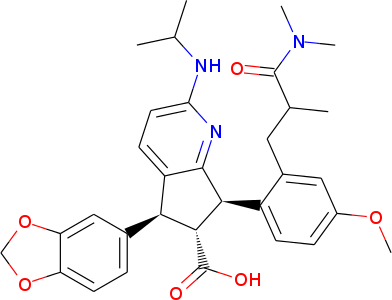
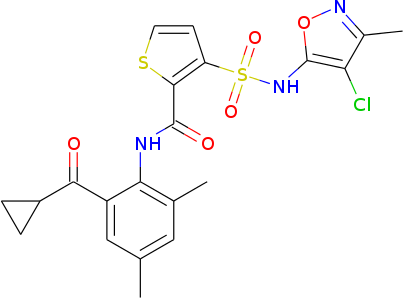
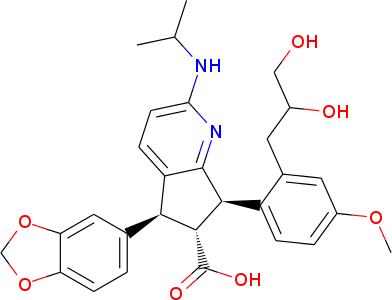
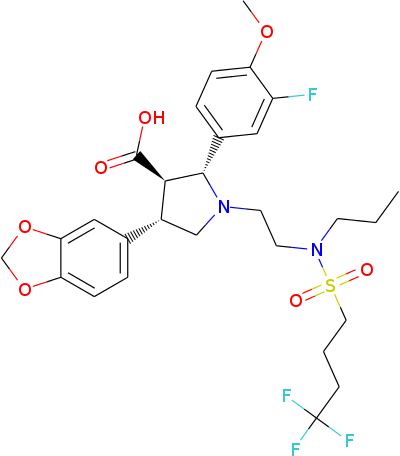
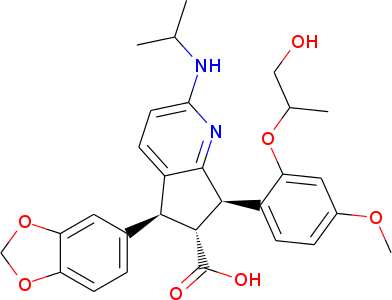
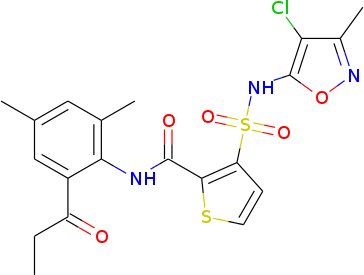
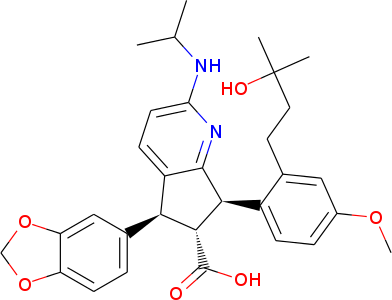
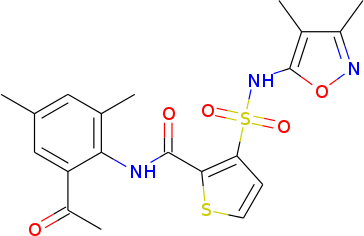
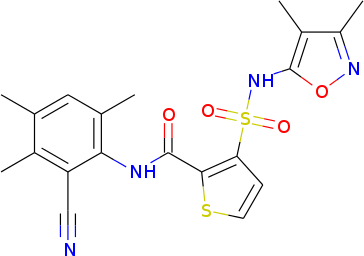
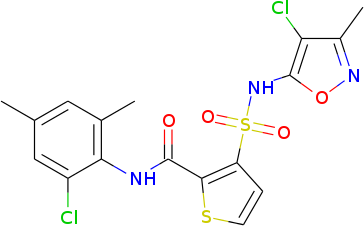
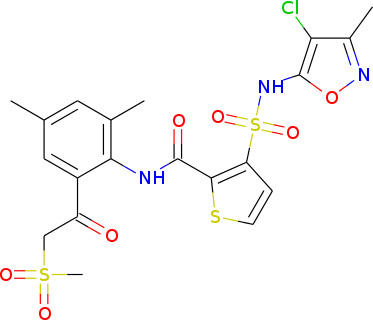
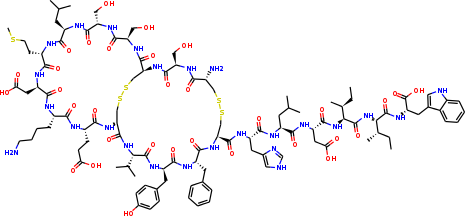
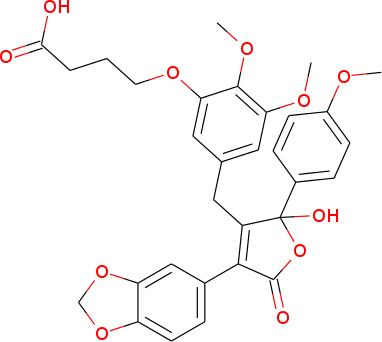
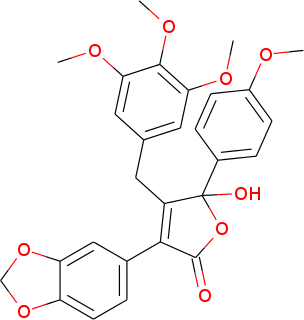
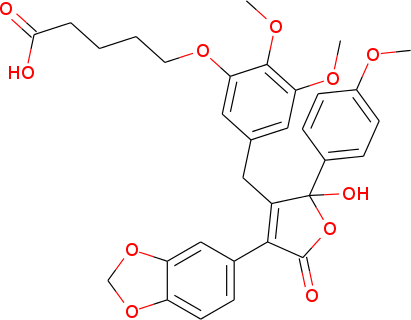
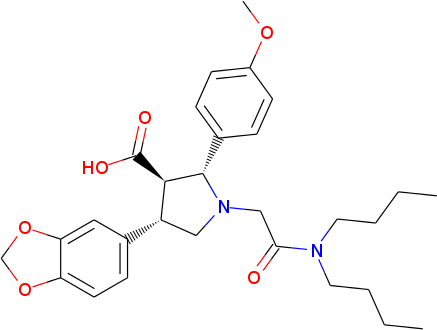
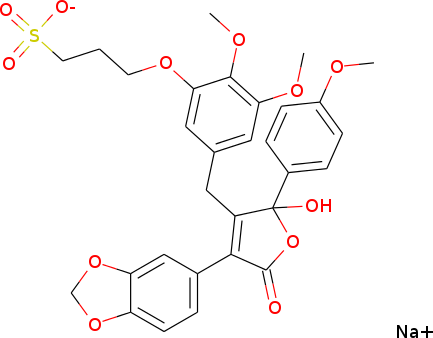
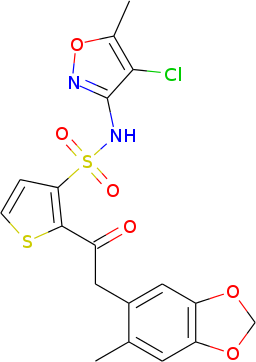
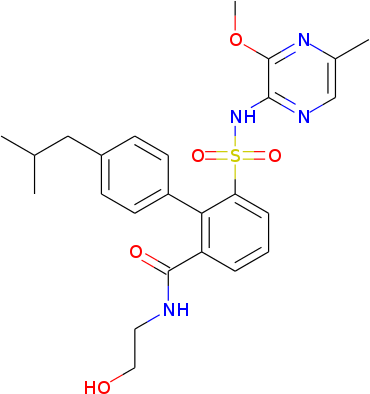
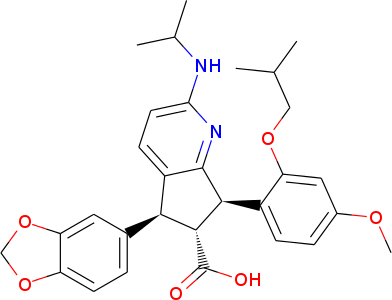
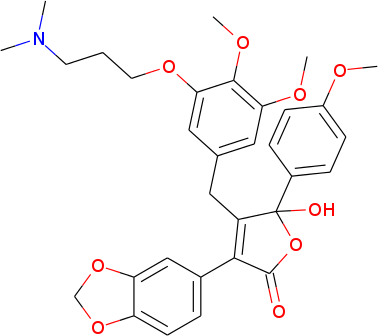
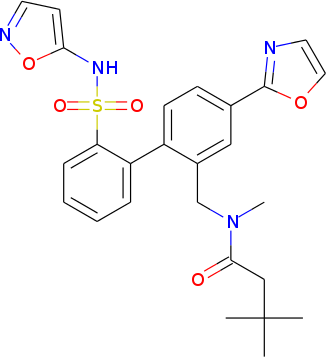
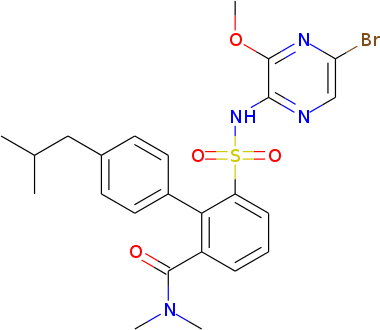
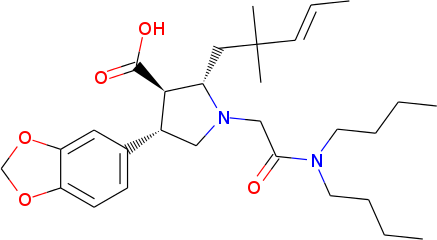
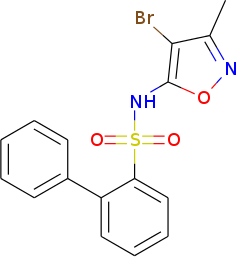

In [10]:
mol_list.table()  # pagesize=10

#### Nested Mol Table
The nested mol table displays the properties next to the structure:


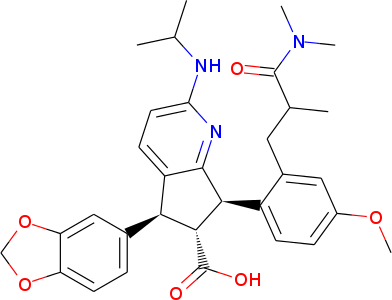
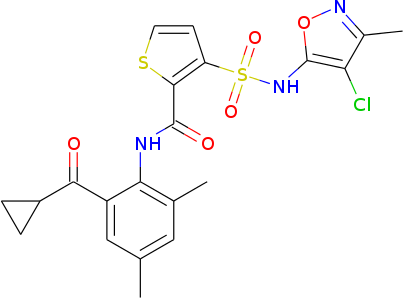
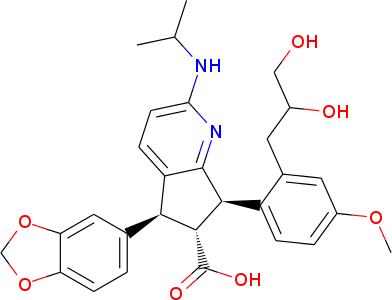
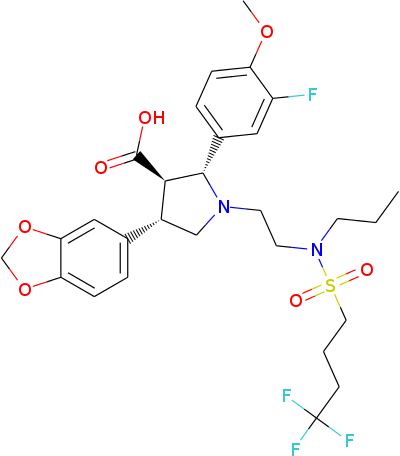
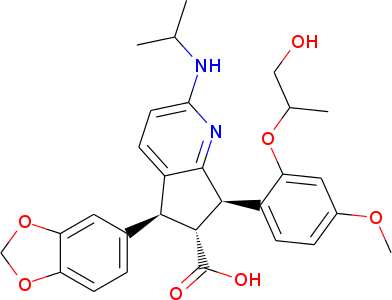
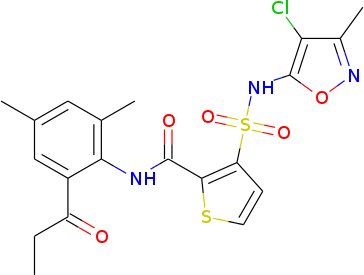
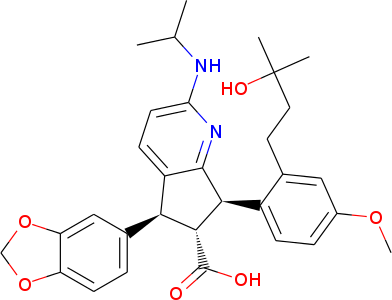
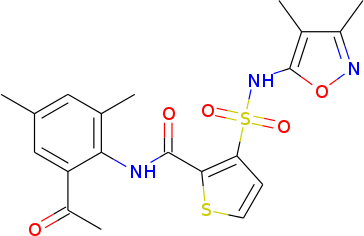
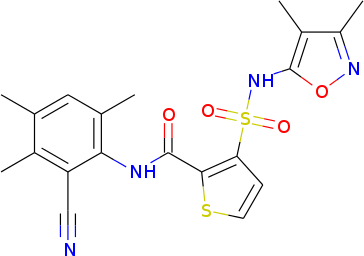
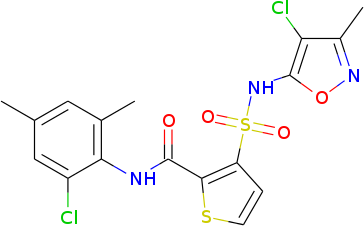

In [11]:
mol_list.nested()  # pagesize=5

#### Grid Table
The grid table displays the molecules in a grid. You can pass additional property names to be shown below the structures (separated by "\_"):

CHEMBL287683,CHEMBL293830,CHEMBL286621,CHEMBL419367
,,,
CHEMBL289216,CHEMBL62112,CHEMBL37920,CHEMBL432521
,,,
CHEMBL58359,CHEMBL293398,CHEMBL305602,CHEMBL437472
,,,

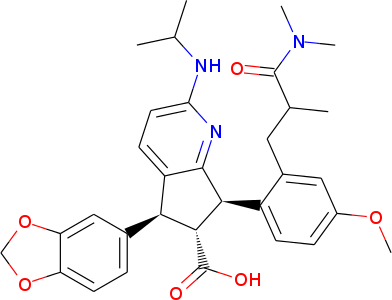
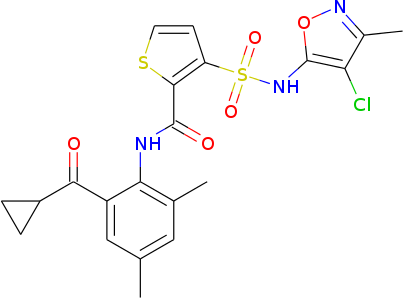
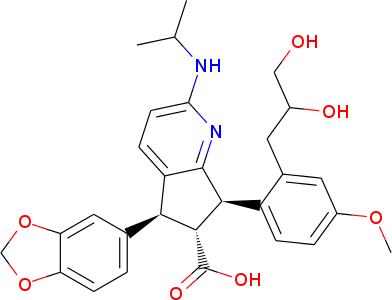
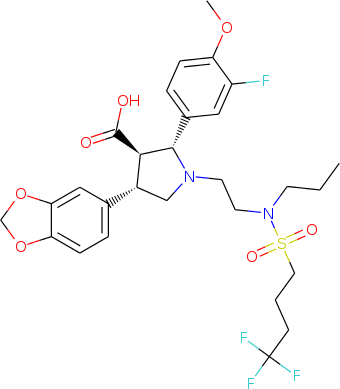
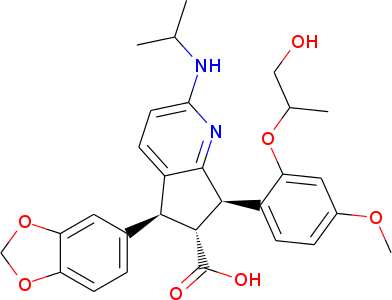
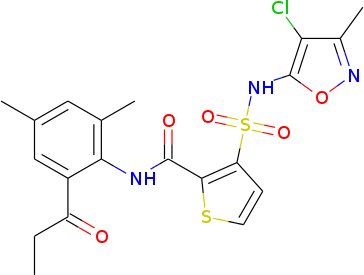
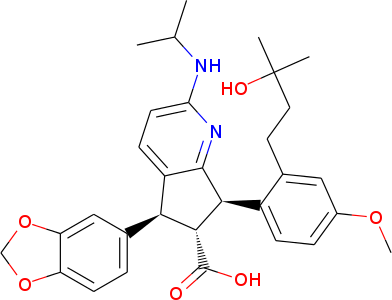
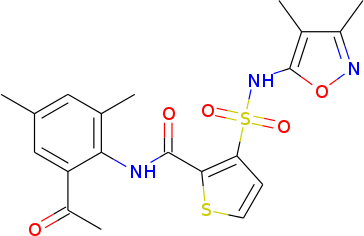
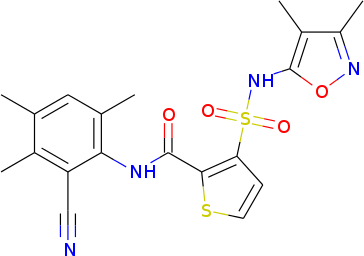
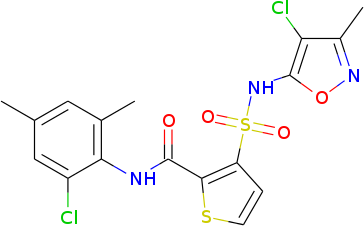
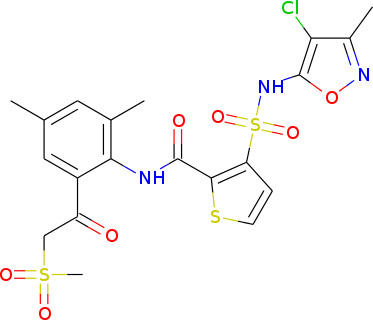
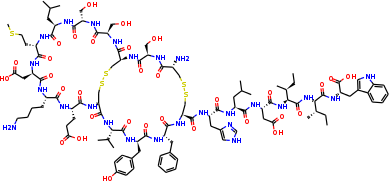

In [12]:
mol_list.grid()  # props="ETA_pIC50"   props=["ETA_pIC50", "TPSA"]

### Data Manipulation and Filtering
**Note:** Mol_List methods that change the length of the list (e.g. filters) return a *new* Mol_List instance (by default an independent copy). 
Methods that do not change the length (e.g. calculating data or renaming fields) modify the list *in-place*.

#### Filter by a Property
* By default, the resulting Mol_List is reversely sorted on the filtered property, if it is numeric
* Text searches are always lower-case!

CHEMBL2058376,CHEMBL322920,CHEMBL322920,CHEMBL322920
,,,
7.52,7.50,7.50,7.50
CHEMBL2058374,CHEMBL2058373,CHEMBL268201,CHEMBL2058371
,,,
7.26,7.15,6.95,6.81
CHEMBL2058375,CHEMBL71070,CHEMBL2058372,CHEMBL2058370
,,,
6.64,6.52,6.51,6.50

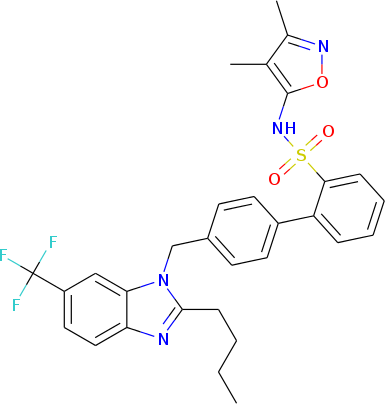
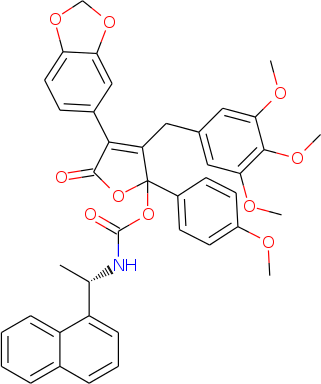
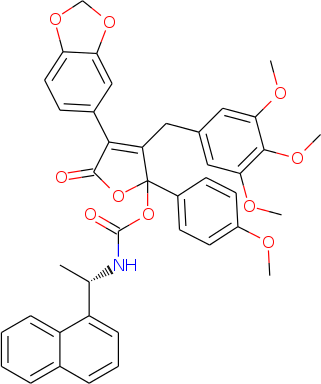
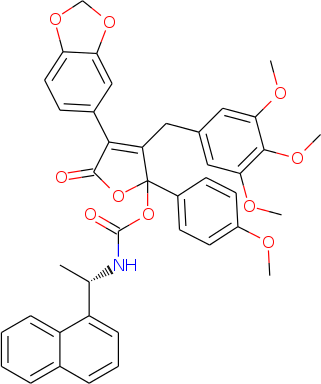
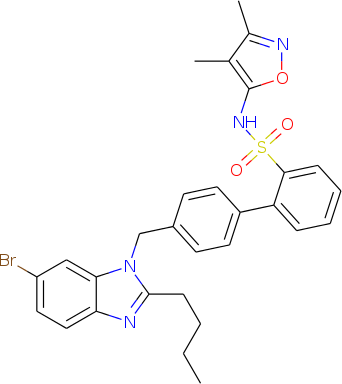
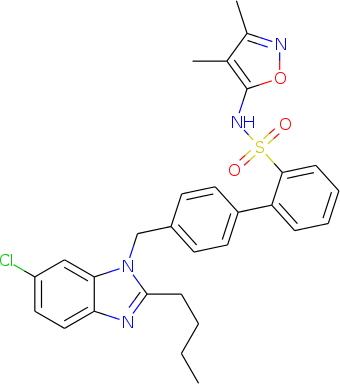
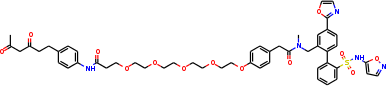
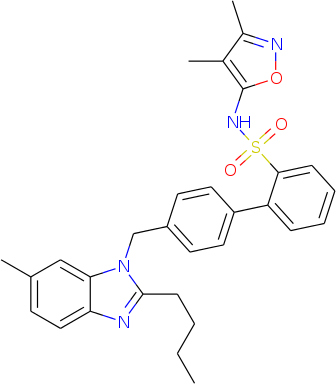
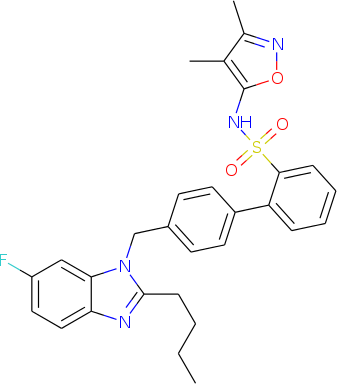
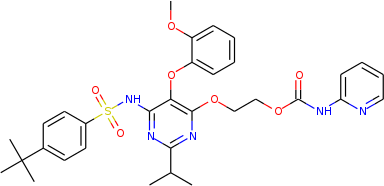
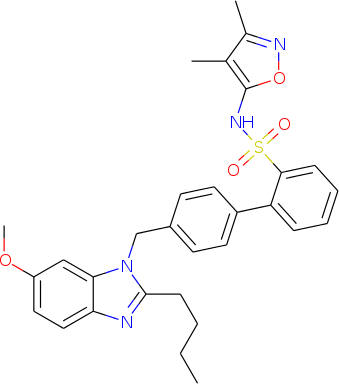
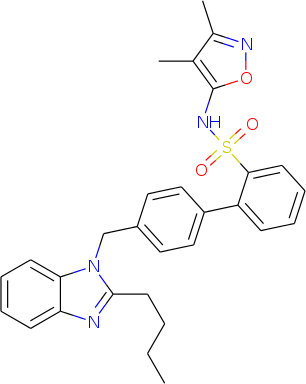

In [13]:
lipophilic = mol_list.prop_filter('LogP >= 5')

lipophilic.grid(props="LogP")

Sort by pIC50 and keep only the 100 most active:
* Sorting is reverse by default!
* Slicing a Mol_List creates a new Mol_List instance.

CHEMBL411925,CHEMBL286621,CHEMBL289634,CHEMBL287683
,,,
10.96,10.96,10.96,10.85
CHEMBL432856,CHEMBL294291,CHEMBL60058,CHEMBL35984
,,,
10.85,10.7,10.7,10.66
CHEMBL287683,CHEMBL289634,CHEMBL37427,CHEMBL293830
,,,
10.62,10.6,10.57,10.52

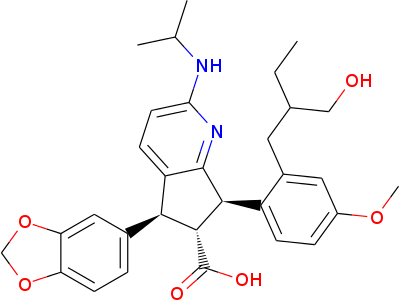
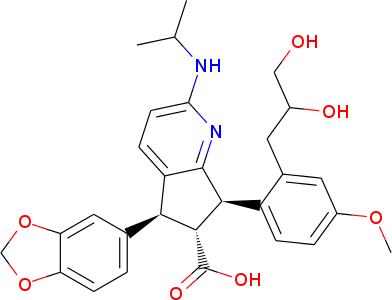
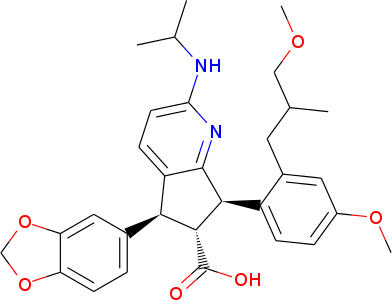
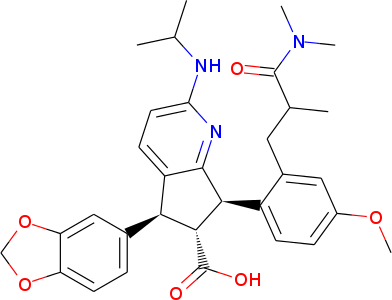
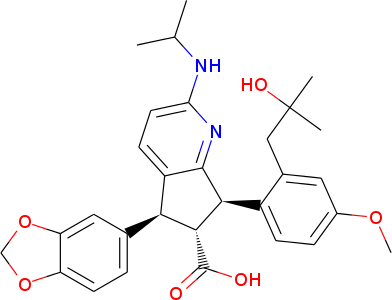
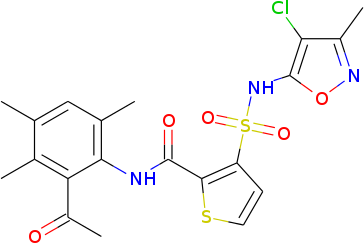
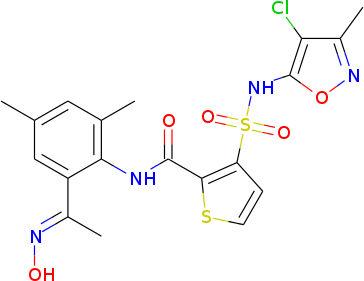
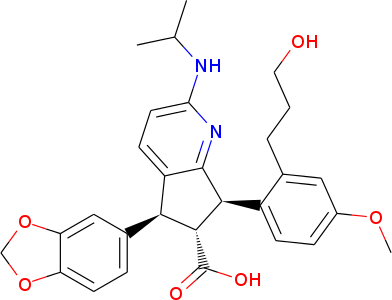
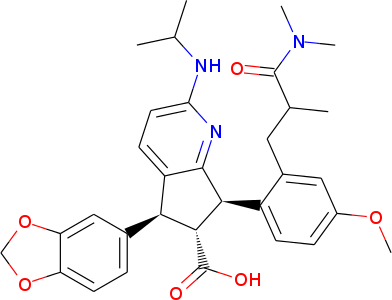
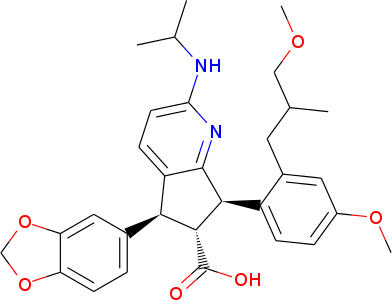
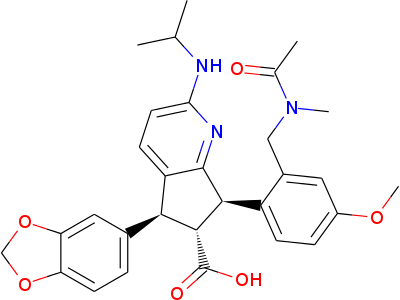
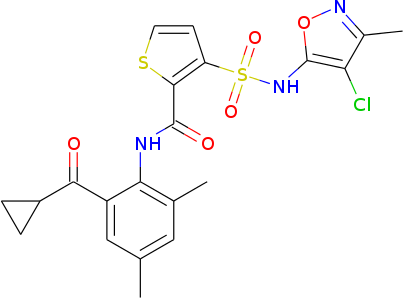

In [14]:
mol_list.sort_list("ETA_pIC50")  # reverse by default!
most_act = mol_list[:100]  # slicing a Mol_List creates a new Mol_List instance.

most_act.grid(props="ETA_pIC50")

#### Filter by Substructure

In [15]:
smi = "c2ccc(c1ccccc1)cc2"
biphenyl = mol_list.mol_filter(smi)

> processed:     430   found:     28


CHEMBL32066,CHEMBL282187,CHEMBL31544,CHEMBL31763
,,,
CHEMBL238539,CHEMBL286014,CHEMBL285976,CHEMBL32572
,,,
CHEMBL80857,CHEMBL58058,CHEMBL241460,CHEMBL31592
,,,

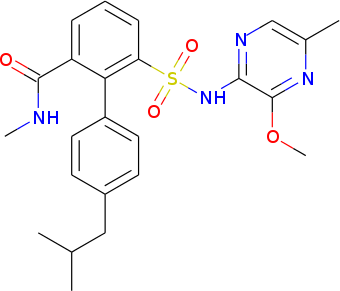
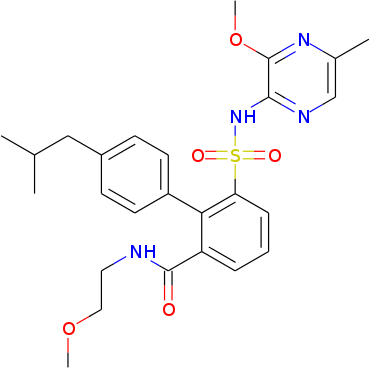
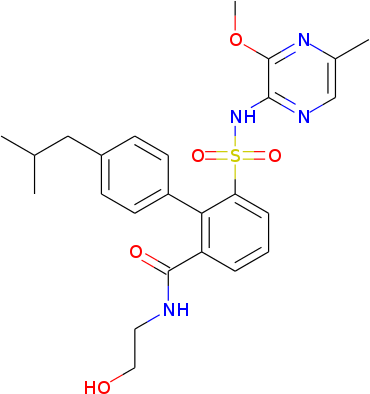
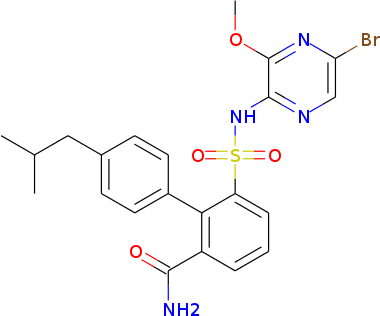
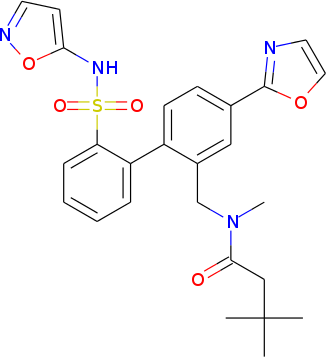
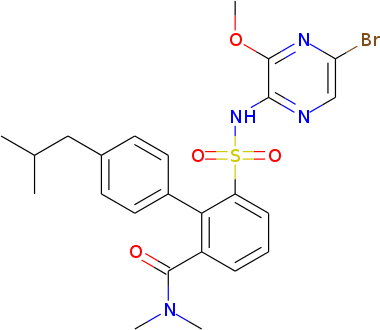
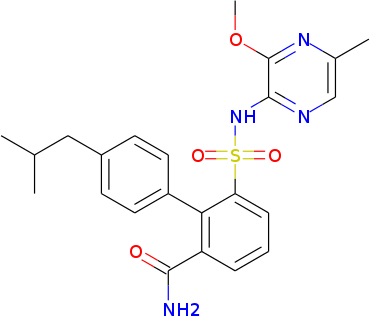
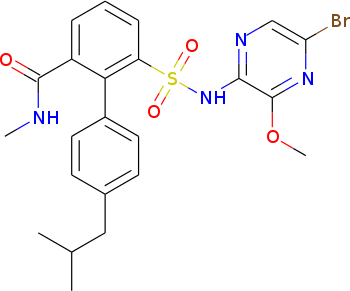
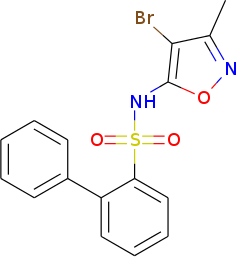
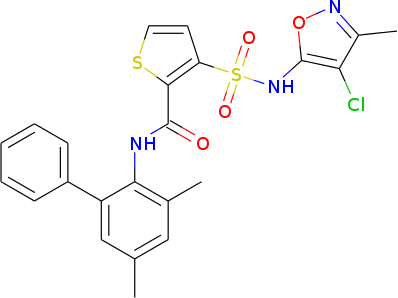
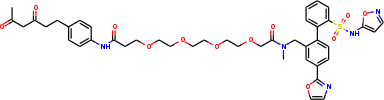
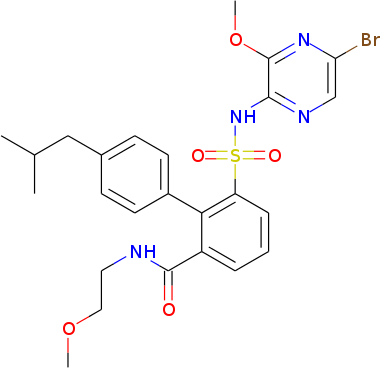

In [16]:
biphenyl.grid()

But where does the Smiles come from?

Wouldn't it be nice, if we could actually draw the structure we want to search in the notebook?<br>
Introducing...

#### The Javascript Molecule Editor (JSME, &#169; Peter Ertl) INSIDE the Jupyter Notebook
(**note:** the JSME widget is only displayed when you actually run the cell, not when you just view the notebook, e.g. in NBViewer. Also, the state of the editor is not saved, so for documentation purposes, the drawn molecule should be displayed in the notebook afterwards.)

When clicking `done`, a global RDKit mol object becomes available, which can be further processed. Other names for the mol object can be used by passing them as string to the jsme() function.

In [26]:
tools.jsme()

,done !


In [17]:
smi = Chem.MolToSmiles(mol)
smi

'c1ccc(-c2ccccc2)cc1'

CHEMBL32066,CHEMBL282187,CHEMBL31544,CHEMBL31763
,,,
CHEMBL238539,CHEMBL286014,CHEMBL285976,CHEMBL32572
,,,
CHEMBL80857,CHEMBL58058,CHEMBL241460,CHEMBL31592
,,,

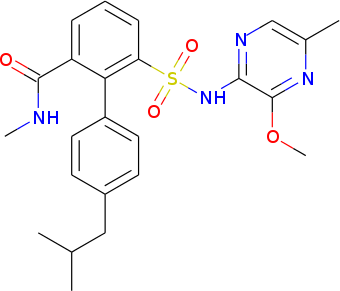
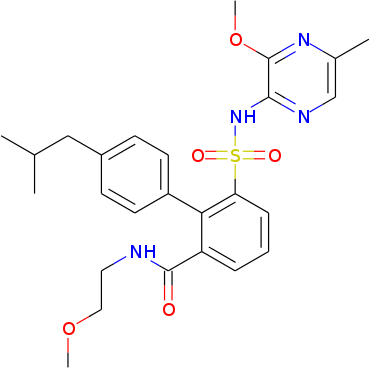
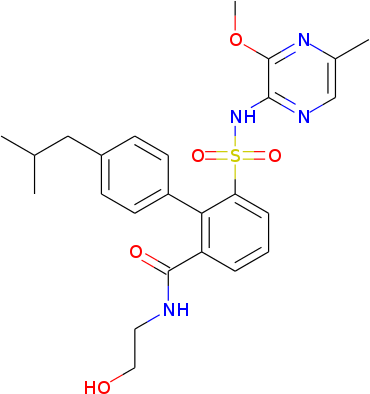
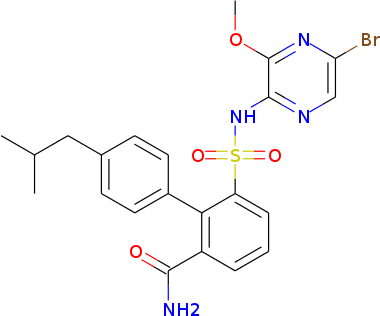
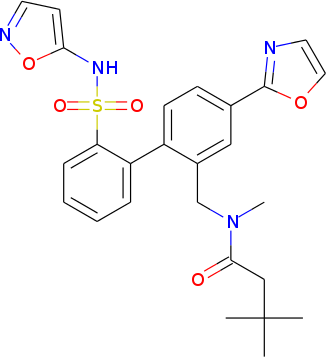
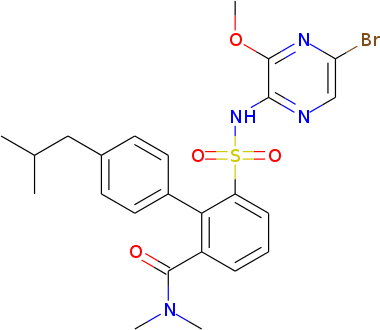
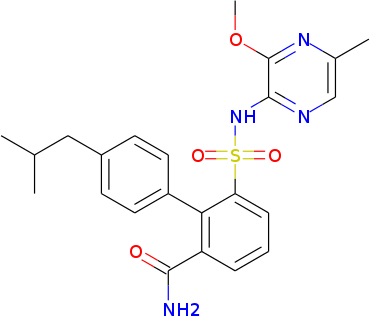
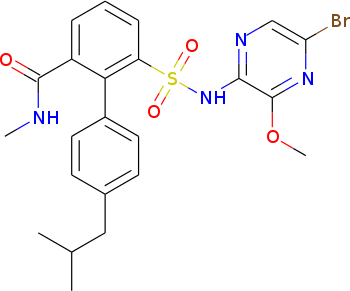
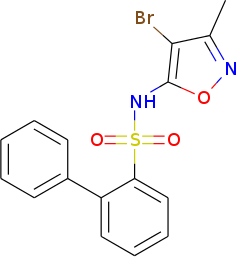
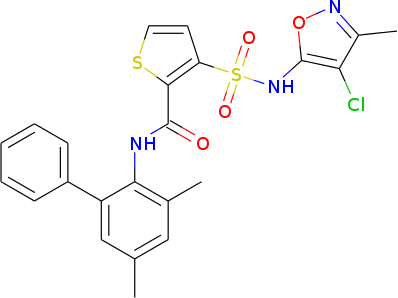
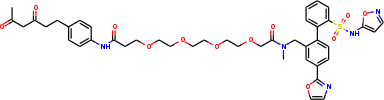
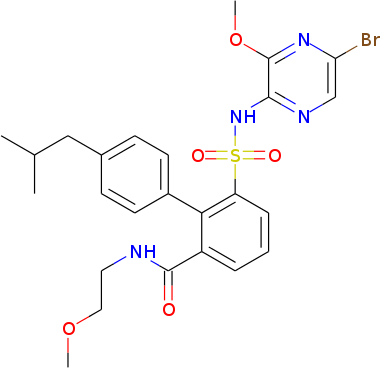

In [18]:
biphenyl = mol_list.mol_filter(smi)
biphenyl.grid()

### Plotting
Using Highcharts or Bokeh. Bokeh is preferred and is actively developed.<br>
The plots are interactive (can be panned, zoomed) and contain structure tooltips!! &nbsp;&nbsp;&nbsp; \o/

The plotting functionality can also be used on its own with dictionaries or Pandas objects as input.

In [19]:
biphenyl.scatter("LogP", "ETA_pIC50")

In [20]:
biphenyl.hist("ETA_pIC50")

### What Else?

#### Methods
* Calculate properties (2d, date, formula, smiles, hba, hbd, logp, molid, mw, rotb, sa (synthetic accessibility), tpsa)
* Generate a new Mol_List from a list of Ids
* Remove duplicates by Id or by structure
* Keep / remove properties
* Add default properties

#### Properties
* order: define the order (as list of property names), in which the properties are displayed in the HTML reports
  * e.g.: `mol_list.order = ["Compound_Id", "ETA_pIC50", "LogP"]`
  * the list does not have to be complete, the other properties follow after the ordered ones
* id_prop: define the name of the property used for identifying molecules  
(by default, a property ending with "id" (case-insensitive) is taken)